## NLP Example

SHAP has specific support for natural language models like those in the Hugging Face transformers library. By adding coalitional rules to traditional Shapley values we can form games that explain large modern NLP model using very few function evaluations. Using this functionality is as simple as passing a supported transformers pipeline to SHAP:

In [1]:
import transformers
import shap

In [2]:
# load a transformers pipeline model
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

In [3]:
# explain the model on sample input
explainer = shap.Explainer(model) 
shap_values = explainer(["What a great movie! ...if you have no taste."])

In [4]:
# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, "POSITIVE"])

## Deep Learning Example with DeepExplainer (TensorFlow/Keras models)

Deep SHAP is a high-speed approximation algorithm for SHAP values in deep learning models that builds on a connection with DeepLIFT described in the SHAP NIPS paper. The implementation here differs from the original DeepLIFT by using a distribution of background samples instead of a single reference value, and using Shapley equations to linearize components such as max, softmax, products, divisions, etc. Note that some of these enhancements have also been since integrated into DeepLIFT. TensorFlow models and Keras models using the TensorFlow backend are supported (there is also preliminary support for PyTorch):

**1. first deep learning - the training and testing part**

In [1]:
# ...include code from https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [2]:
# load the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 10s 1us/step


In [3]:
# setup hpyer parameter
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
# build model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [5]:
# train model
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/12
469/469 [==============================] - 76s 161ms/step - loss: 2.2908 - accuracy: 0.1338 - val_loss: 2.2499 - val_accuracy: 0.3274
Epoch 2/12
469/469 [==============================] - 84s 179ms/step - loss: 2.2446 - accuracy: 0.2457 - val_loss: 2.1859 - val_accuracy: 0.5572
Epoch 3/12
469/469 [==============================] - 88s 189ms/step - loss: 2.1812 - accuracy: 0.3784 - val_loss: 2.0982 - val_accuracy: 0.6431
Epoch 4/12
469/469 [==============================] - 80s 170ms/step - loss: 2.0966 - accuracy: 0.4621 - val_loss: 1.9781 - val_accuracy: 0.6995
Epoch 5/12
469/469 [==============================] - 96s 206ms/step - loss: 1.9795 - accuracy: 0.5182 - val_loss: 1.8173 - val_accuracy: 0.7218
Epoch 6/12
469/469 [==============================] - 72s 153ms/step - loss: 1.8312 - accuracy: 0.5567 - val_loss: 1.6191 - val_accuracy: 0.7386
Epoch 7/12
469/469 [==============================] - 91s 194ms/step - loss: 1.6509 - accuracy: 0.5939 - val_loss: 1.4026 - val_ac

In [7]:
# validate model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7305663824081421
Test accuracy: 0.838100016117096


**2. now the explainability part**

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


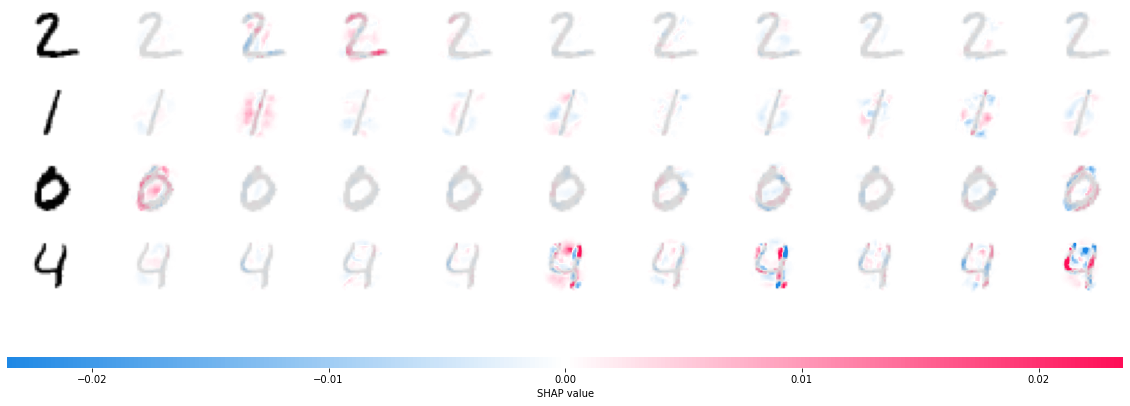

In [8]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])

he plot above explains ten outputs (digits 0-9) for four different images. Red pixels increase the model's output while blue pixels decrease the output. The input images are shown on the left, and as nearly transparent grayscale backings behind each of the explanations. The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset) and the current model output. Note that for the 'zero' image the blank middle is important, while for the 'four' image the lack of a connection on top makes it a four instead of a nine.

## Deep learning example with GradientExplainer (TensorFlow/Keras/PyTorch models)

Expected gradients combines ideas from Integrated Gradients, SHAP, and SmoothGrad into a single expected value equation. This allows an entire dataset to be used as the background distribution (as opposed to a single reference value) and allows local smoothing. If we approximate the model with a linear function between each background data sample and the current input to be explained, and we assume the input features are independent then expected gradients will compute approximate SHAP values. In the example below we have explained how the 7th intermediate layer of the VGG16 ImageNet model impacts the output probabilities.

In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [9]:
# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)


553467904/553467096 [==============================] - 151s 0us/step


In [34]:
# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input.ref()], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

AttributeError: module 'keras.backend' has no attribute 'get_session'

Predictions for two input images are explained in the plot above. Red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values the reduce the probability of the class. By using ranked_outputs=2 we explain only the two most likely classes for each input (this spares us from explaining all 1,000 classes).

**same problem with pytorch**

In [35]:
import torch, torchvision
from torch import nn
from torchvision import transforms, models, datasets
import shap
import json
import numpy as np

In [36]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

In [38]:
# load the model
model = models.vgg16(pretrained=True).eval()

X,y = shap.datasets.imagenet50()

X /= 255

to_explain = X[[39, 41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

In [40]:
# I am decreasing the number of samples,
e = shap.GradientExplainer((model, model.features[7]), normalize(X))
shap_values,indexes = e.shap_values(normalize(to_explain), ranked_outputs=2, nsamples=10)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

KeyboardInterrupt: 

### Explain with local smoothing
Gradient explainer uses expected gradients, which merges ideas from integrated gradients, SHAP, and SmoothGrad into a single expection equation. To use smoothing like SmoothGrad just set the local_smoothing parameter to something non-zero. This will add normally distributed noise with that standard deviation to the input during the expectation calculation. It can create smoother feature attributions that better capture correlated regions of the image.

In [ ]:
# note that because the inputs are scaled to be between 0 and 1, the local smoothing also has to be
# scaled compared to the Keras model
explainer = shap.GradientExplainer((model, model.features[7]), normalize(X), local_smoothing=0.5)
shap_values,indexes = explainer.shap_values(normalize(to_explain), ranked_outputs=2, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

## Model agnostic example with KernelExplainer (explains any function)

Kernel SHAP uses a specially-weighted local linear regression to estimate SHAP values for any model. Below is a simple example for explaining a multi-class SVM on the classic iris dataset.

In [41]:
import sklearn
import shap
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/30 [00:00<?, ?it/s]

The above explanation shows four features each contributing to push the model output from the base value (the average model output over the training dataset we passed) towards zero. If there were any features pushing the class label higher they would be shown in red.

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset. This is exactly what we do below for all the examples in the iris test set:

In [42]:
# plot the SHAP values for the Setosa output of all instances
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")

In [44]:
explainer.expected_value[0]

-0.7481541776656553